# Classification and Logistic Regression

## Fixing Dr. Oak's Pokedex (Pokemon data)

Help Dr. Oak create a predictive model to predict a pokeomn's `Legendary` status based on other pokemon charecteristics:

More formally:

$y$ (response): Legendary (True, False)

$X$ (predictors): other pokemon charecteristics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import copy

# old imports from sklearn!
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# new imports from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, \
  classification_report,roc_auc_score

In [2]:
path = './'
df = pd.read_csv(path + 'Pokemon.csv', encoding ='latin1')
df.head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Stage,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,2,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,3,False
3,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
4,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,2,False


At first this looks promising:

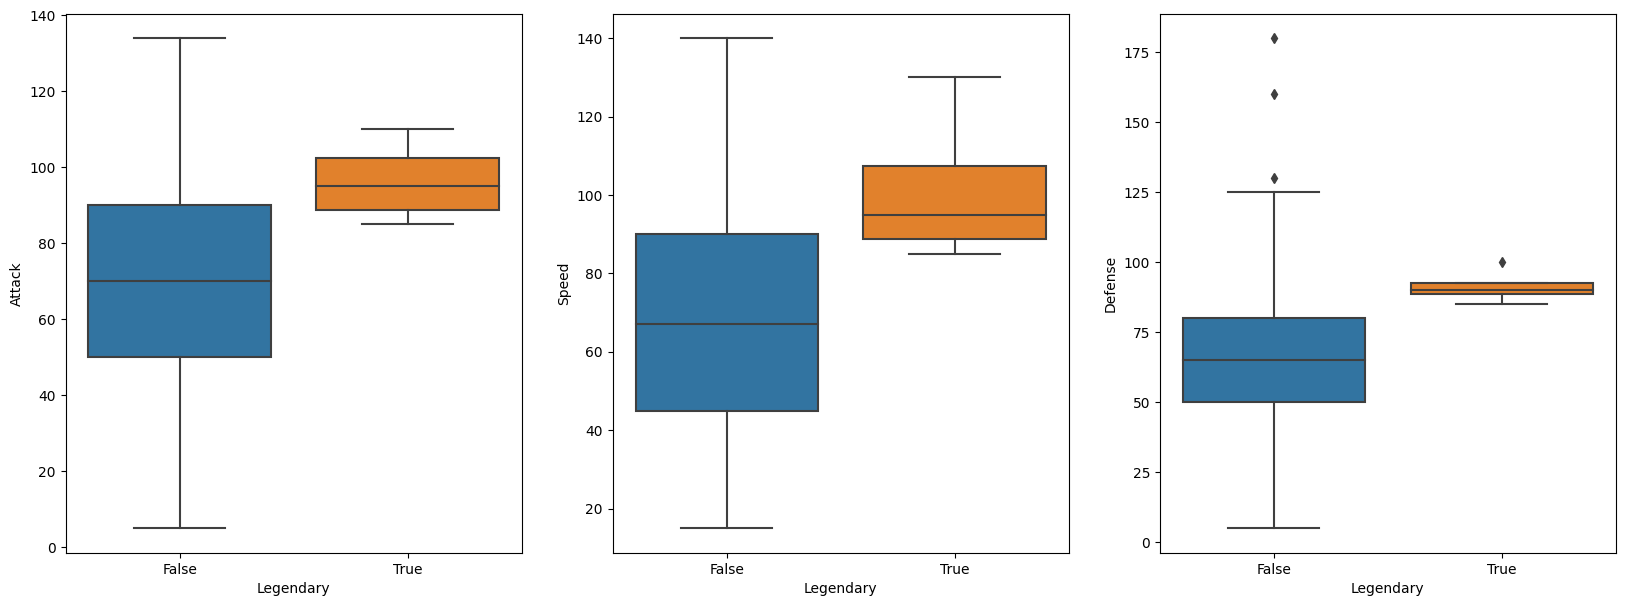

In [3]:
fig, ax = plt.subplots(ncols=3, figsize=(20,7))
sns.boxplot(x='Legendary',y='Attack', data=df, ax = ax[0])
sns.boxplot(x='Legendary',y='Speed', data=df, ax = ax[1])
sns.boxplot(x='Legendary',y='Defense', data=df, ax = ax[2])
plt.show()

But then...

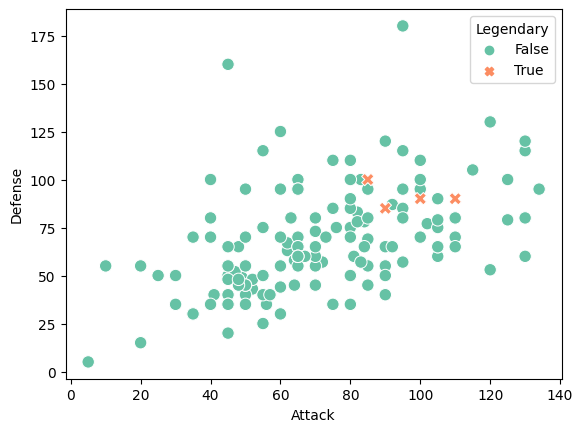

In [4]:
sns.scatterplot(x='Attack', y='Defense', hue='Legendary',
                style='Legendary', s=80, palette="Set2", data=df)
plt.show()

In [5]:
# yes, only 4.
df['Legendary'].value_counts()

False    147
True       4
Name: Legendary, dtype: int64

**Questions**:
* What do you think a model's chance of correctly identifying `Legendary`
* What real-life scenario this resembles?

## Classification Metrics

* The **confusion matrix** is classification's main evaluation tool

|        |   Pred    ||
|--------|-----|-----|
|**Real**| Pos | Neg |
|Pos     | TP  | FN  |
|Neg     | FP  | TN  |

*   __Accuracy__: the fraction of predictions the model got right
$$ Accuracy =P(Correct) = \frac{TP+TN}{TP+TN+FP+FN}$$

*   __Precision__(PPV): the proportion of positive identifications was actually correct
$$ Precision = P(True + | Pred +) = \frac{TP}{TP+FP}$$

*   __Recall__(TPR, Sensitivity): the proportion of actual positives was identified correctly

$$ Recall= P(Pred + | True +) = \frac{TP}{TP+FN}$$

* Of course precision and recall are also important for the $Neg$ class:
$$PPV \to NPV$$

$$TPR, Sensitivity \to TNR, Specificity$$

* And there's also $$ FPR = P(Pred + | True -) = \frac{FP}{FP + TN} = 1 - Specificity$$

*   __F1score__: the harmonic mean of precision and recall

$$ F1=2\cdot\frac{precision \cdot recall}{precision+recall}$$


[More information on wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

## Logistic Regression

**Question**:
Why not do linear regression? (in fact, go ahead!) 

Remember $Y$ is binary, therefore we model it with Bernoulli distribution:

$$Y_i|X_i \sim Bernoulli(p_i) \to P(Y_i = y_i|X_i) = p_i^{y_i}(1-p_i)^{1-y_i} \\
\to E(Y_i|X_i) = P(Y_i = 1| X_i) = p_i$$

It is **this** $E(Y)$ that we model, through some link function $g$, in our case the $\text{logit}$ function, so:

$$g(E(Y_i)) = g(p_i) = \text{logit}(p_i) = \log\left(\frac{p_i}{1-p_i}\right) = \beta_0 + \beta_1X_{1i} + \dots + \beta_pX_{pi}$$

Once we get our estimate $\hat\beta$:
* We could "explain" $Y_i$, the size and direction of each component of $\hat\beta$ indicating the contribution of that predictor to the *log-odds* of $Y_i$ being $1$
* We could estimate the probability a of new observation $X_i$ to have $Y_i=1$ by fitting a probability $\hat p_i=\frac{1}{1+e^{-X_i\hat\beta}}$, where typically if $\hat p_i > 0.5$, or $X_i\hat\beta > 0$, we predict $Y_i=1$
* Then calculate accuracy, precision, recall, AUC, to evaluate the model

**Question**:
How do we get $\hat{\beta}$?

In [6]:
X = df[['Attack','Speed']]
y = df['Legendary']

lr = LogisticRegression(penalty=None) # amazingly the default penalty is 'l2', for older sklearn use 'none'
_ = lr.fit(X, y)
b = np.concatenate([lr.intercept_, lr.coef_[0]])
print(f'logit(P(Legendary)) = {b[0]:.02f} + {b[1]:.02f}*Attack + {b[2]:.02f}*Speed')

logit(P(Legendary)) = -11.32 + 0.04*Attack + 0.05*Speed


**Question**:
* What is "-11.32"? What is "0.04"?

Note the `predict_proba()` method returns a $n \times 2$ matrix:

In [7]:
lr.predict_proba(X)[:10]

array([[9.99208230e-01, 7.91770439e-04],
       [9.97191645e-01, 2.80835538e-03],
       [9.83379768e-01, 1.66202321e-02],
       [9.97511060e-01, 2.48894034e-03],
       [9.91534378e-01, 8.46562209e-03],
       [9.51259232e-01, 4.87407680e-02],
       [9.99312463e-01, 6.87537141e-04],
       [9.97368930e-01, 2.63107048e-03],
       [9.84415338e-01, 1.55846625e-02],
       [9.99614756e-01, 3.85243578e-04]])

Predict the class **with a default threshold of 0.5**:

In [8]:
lr.predict(X)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Get confustion matrix:

In [9]:
y_pred = lr.predict(X)
pd.DataFrame(data = confusion_matrix(y, y_pred),
             index = ['Not_legend','legend'],
             columns=['Pred_not_legend', 'Pred_legend'])

,Pred_not_legend,Pred_legend
Not_legend,147,0
legend,4,0


Get precision and recall for each class with `classification_report()`

**Note**: You have to be able to calculate these yourself from the CM.

In [10]:
target_names = ['False_Legend', 'True_Legend']
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

False_Legend       0.97      1.00      0.99       147
 True_Legend       0.00      0.00      0.00         4

    accuracy                           0.97       151
   macro avg       0.49      0.50      0.49       151
weighted avg       0.95      0.97      0.96       151



C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

So this is just terrible, thank God for the warnings.

But when plotting the ROC (Recall-Pos vs. 1 - Recall-Neg, or: Sensitivity vs. 1 - Specificity, or: TPR vs. FPR):

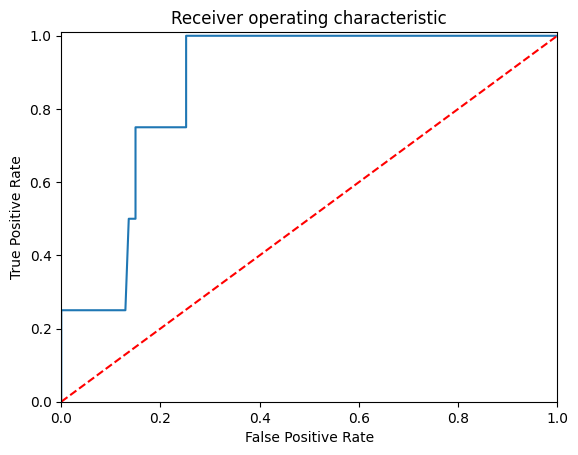

AUC: 0.87


In [11]:
y_pred_prob = lr.predict_proba(X)[:, 1]
auc = roc_auc_score(y, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

print(f'AUC: {auc:.02f}')

The AUC is looks OK though. What is going on?

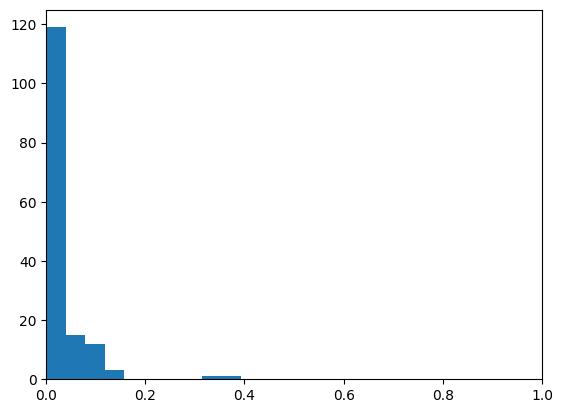

In [12]:
plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.show()

The 0.5 threshold is very wrong, as the model was trained on a completely imbalanced data returning very low scores.

A Pokemon might be "Legendary" based on a much lower threshold:


In [13]:
thresh = 4/151

y_pred_thresh = y_pred_prob > thresh

pd.DataFrame(data = confusion_matrix(y, y_pred_thresh),
             index = ['Not_legend','legend'],
             columns=['Pred_not_legend','Pred_legend'])

,Pred_not_legend,Pred_legend
Not_legend,111,36
legend,1,3


In [14]:
target_names = ['False_Legend', 'True_Legend']
print(classification_report(y, y_pred_thresh, target_names=target_names))

              precision    recall  f1-score   support

False_Legend       0.99      0.76      0.86       147
 True_Legend       0.08      0.75      0.14         4

    accuracy                           0.75       151
   macro avg       0.53      0.75      0.50       151
weighted avg       0.97      0.75      0.84       151



**Note**:
* As said in class for bottom-line 0/1 prediction we need a good **ranking** not necessarily fitted probabilities, that is why AUC is often used
* Precision for declaring "Legend" is still very small
* Do you think this would prove useful on unseen Pokemons?
* Data so small AND so imbalanced?... Problematic.

### Q1.

I fit a logistic regression model with some training data $(X, Y)$ and get $\hat{\beta}$ and a vector of estimated probabilities $\hat{p}$.

As usual, I had a bug in my ETL, and I forgot to subtract 1 from all data in the first column of $X$.

What happens to $\hat{\beta}, \hat{p}$?

1. $\hat{\beta}$ changes in the first coordinate, $\hat{p}$ unchanged
2. $\hat{\beta}$ changes in all coordinates, $\hat{p}$ unchanged
3. $\hat{\beta}$ unchanged, $\hat{p}$ unchanged
4. $\hat{\beta}$ changes in the first coordinate, $\hat{p}$ changes

## Multinomial Regression

Suppose we want to generalize to $K$ classes, for example $K = 3$ with the `Stage` variable.

One approach: the one-versus-rest approach, or OVR
* splitting the multi-class dataset into multiple binary classification problems
* train a binary classifier (e.g. logistic regression) on 1 class vs. all other classes
* in prediction choose the class with highest score

There are however more theory-driven approaches like Multinomial Regression, here we just demonstrate:

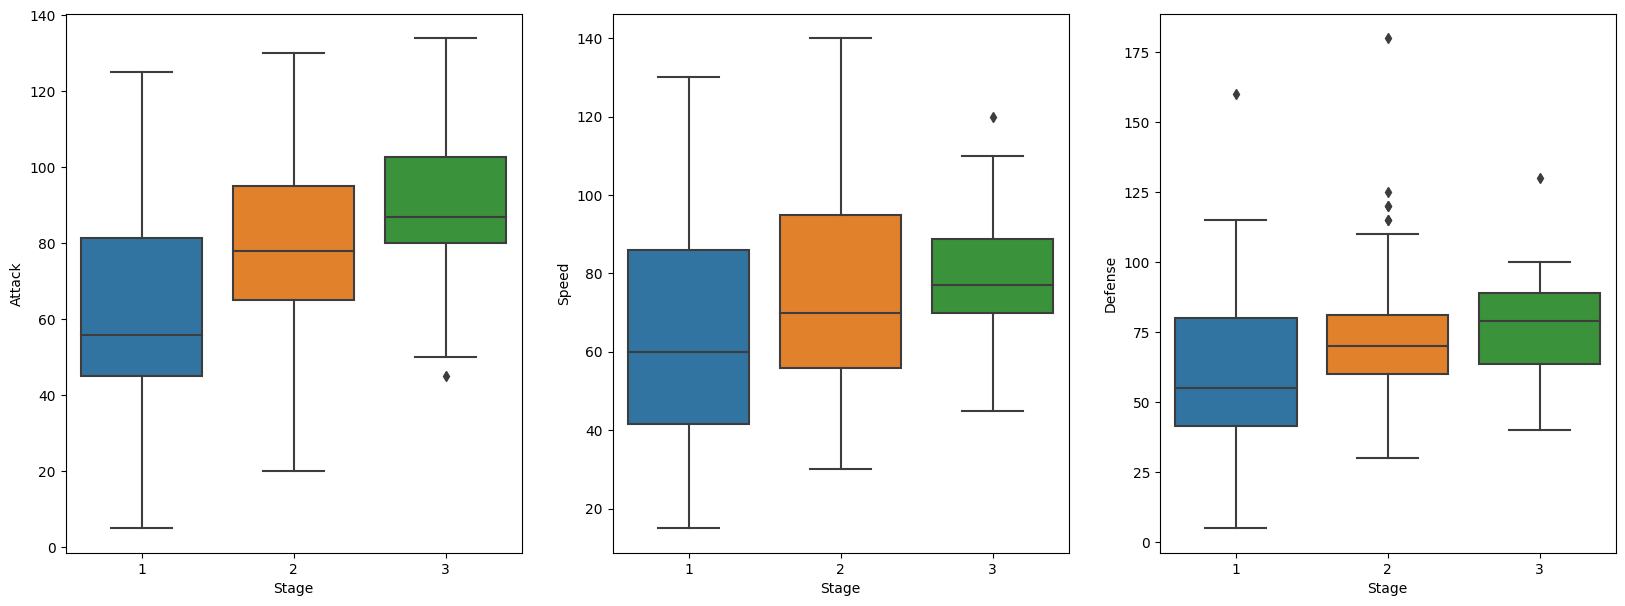

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(20,7))
sns.boxplot(x='Stage',y='Attack', data=df, ax = ax[0])
sns.boxplot(x='Stage',y='Speed', data=df, ax = ax[1])
sns.boxplot(x='Stage',y='Defense', data=df, ax = ax[2])
plt.show()

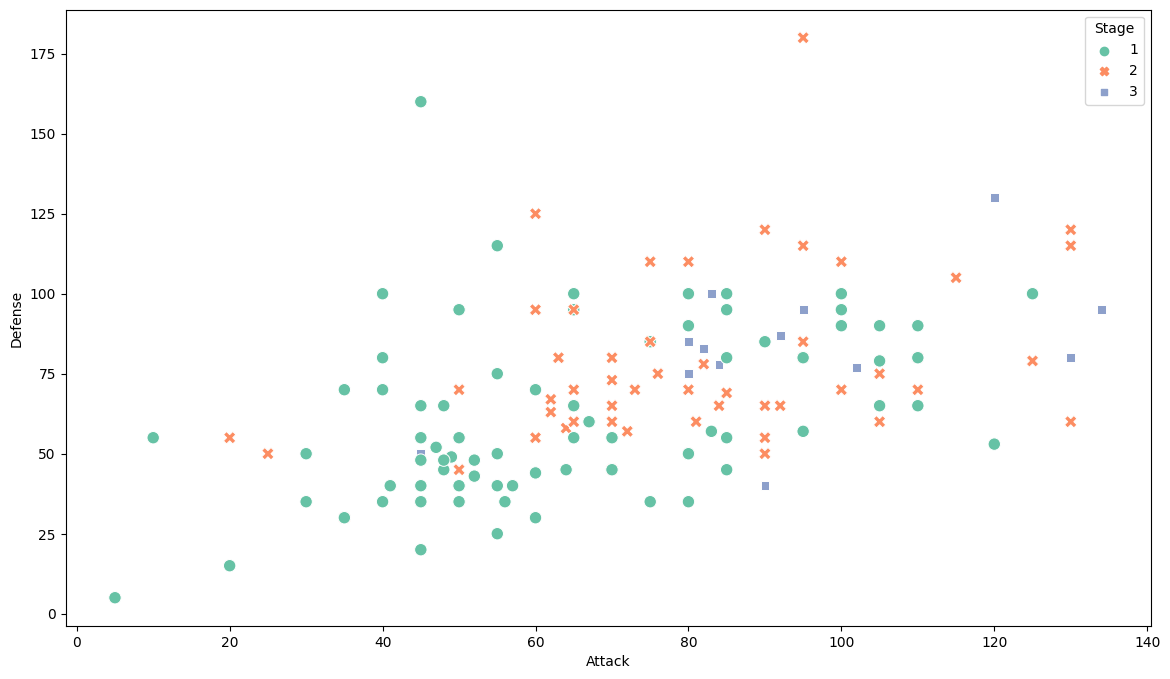

In [16]:
plt.subplots(figsize=(14,8))
sns.scatterplot(x='Attack', y='Defense', hue='Stage', style='Stage', s=80, palette="Set2", data=df)
plt.show()

Slightly more balanced:

In [17]:
df['Stage'].value_counts()

1    79
2    56
3    16
Name: Stage, dtype: int64

Multinomial Regression with no explanations...

In [19]:
X = df[['Attack','Speed']]
y = df['Stage']

mr = LogisticRegression(multi_class='multinomial', penalty=None)
_ = mr.fit(X, y)
print(mr.coef_) # do not interpret without delving into multinomial regression

[[-0.02112558 -0.01130952]
 [ 0.00311687  0.00313984]
 [ 0.01800871  0.00816968]]


In [20]:
mr.predict_proba(X)[:10]

array([[0.75130387, 0.21772325, 0.03097288],
       [0.63087206, 0.31119196, 0.05793598],
       [0.42265216, 0.45200475, 0.12534309],
       [0.67361442, 0.28027943, 0.04610616],
       [0.54410146, 0.37612246, 0.07977608],
       [0.33645027, 0.50424673, 0.159303  ],
       [0.76165842, 0.20930061, 0.02904096],
       [0.63177894, 0.31019159, 0.05802947],
       [0.42353214, 0.4508417 , 0.12562616],
       [0.83164874, 0.15205133, 0.01629993]])

Predict the class **by maximum score**:

In [21]:
mr.predict(X)

array([1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2],
      dtype=int64)

Get confustion matrix:

In [22]:
y_pred = mr.predict(X)
pd.DataFrame(data = confusion_matrix(y, y_pred),
             index = ['Stage_1','Stage_2', 'Stage_3'],
             columns=['Pred_Stage_1','Pred_Stage_2', 'Pred_Stage_3'])

,Pred_Stage_1,Pred_Stage_2,Pred_Stage_3
Stage_1,61,18,0
Stage_2,29,27,0
Stage_3,3,13,0


Get precision and recall for each class with `classification_report()`

**Note**: You have to be able to calculate these yourself from the CM.

In [23]:
target_names = ['Stage_1','Stage_2', 'Stage_3']
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Stage_1       0.66      0.77      0.71        79
     Stage_2       0.47      0.48      0.47        56
     Stage_3       0.00      0.00      0.00        16

    accuracy                           0.58       151
   macro avg       0.37      0.42      0.39       151
weighted avg       0.52      0.58      0.55       151



C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

There are more efficient ways to get different thresholds but this is self-explanatory:

In [24]:
def pred_func(preds, t1=0.15, t2=0.3):
  if preds[2] > t1:
    label = 3
  elif preds[1] > t2:
    label = 2
  else:
    label = 1
  return label

In [25]:
y_pred_prob_array = mr.predict_proba(X)
y_pred_thresh = np.apply_along_axis(pred_func, 1, y_pred_prob_array)

In [26]:
pd.DataFrame(data = confusion_matrix(y, y_pred_thresh),
             index = ['Stage_1','Stage_2', 'Stage_3'],
             columns=['Pred_Stage_1','Pred_Stage_2', 'Pred_Stage_3'])

,Pred_Stage_1,Pred_Stage_2,Pred_Stage_3
Stage_1,42,23,14
Stage_2,5,35,16
Stage_3,1,7,8


In [27]:
target_names = ['Stage_1','Stage_2', 'Stage_3']
print(classification_report(y, y_pred_thresh, target_names=target_names))

              precision    recall  f1-score   support

     Stage_1       0.88      0.53      0.66        79
     Stage_2       0.54      0.62      0.58        56
     Stage_3       0.21      0.50      0.30        16

    accuracy                           0.56       151
   macro avg       0.54      0.55      0.51       151
weighted avg       0.68      0.56      0.59       151



The accuracy only slightly decreases while F1-scores increase, could argue this is a better model.

## Relation to Neural Networks

Lastly I just want you to acknowledge the fact that all predictive models so far (linear, logistic, multinomial regression) can be viewed as a simplified case of neural network. More on that in a few weeks I hope.

## KNN

Probably the nicest thing about KNN is that my 7yo twins get it.

In [28]:
from sklearn.neighbors import KNeighborsClassifier

X = df[['Attack','Speed']]
y = df['Stage']

knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
_ = knn.fit(X, y) 

In [29]:
# make sure you understand these numbers
knn.predict_proba(X)[:10]

array([[1.        , 0.        , 0.        ],
       [0.33333333, 0.66666667, 0.        ],
       [0.        , 0.33333333, 0.66666667],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.33333333, 0.66666667],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.33333333, 0.66666667],
       [1.        , 0.        , 0.        ]])

In [30]:
y_pred = knn.predict(X) # again prediction by max prob or majority vote
pd.DataFrame(data = confusion_matrix(y, y_pred),
             index = ['Stage_1','Stage_2', 'Stage_3'],
             columns=['Pred_Stage_1','Pred_Stage_2', 'Pred_Stage_3'])

,Pred_Stage_1,Pred_Stage_2,Pred_Stage_3
Stage_1,67,9,3
Stage_2,12,40,4
Stage_3,4,4,8


In [31]:
target_names = ['Stage_1','Stage_2', 'Stage_3']
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Stage_1       0.81      0.85      0.83        79
     Stage_2       0.75      0.71      0.73        56
     Stage_3       0.53      0.50      0.52        16

    accuracy                           0.76       151
   macro avg       0.70      0.69      0.69       151
weighted avg       0.76      0.76      0.76       151



**Note**:
KNN performed way better. But this is (a single) training data result! Would it generalize to unseen testing data? Check!

### Choosing K

For knn you must select a hyperparameter K. Ideally this would be tuned by CV, here we use all data to make a point.

We compare Euclidean distance and [Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_distance), the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) may surprise you as to what is the default distance in SKlearn.

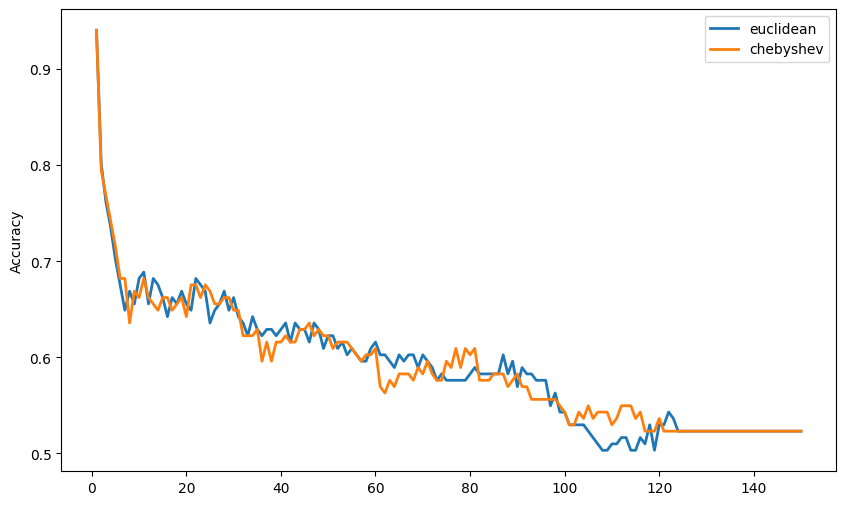

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
dict_metrics ={'euclidean':[], 'chebyshev':[]} 
k_vals = [i for i in range(1,151)]
scores = []

for metric in dict_metrics:
  for k in k_vals:
      knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
      knn.fit(X, y) 
      dict_metrics[metric].append(knn.score(X,y))

  plt.plot(np.array(k_vals), np.array(dict_metrics[metric]), lw = 2)
plt.ylabel('Accuracy')
plt.legend(dict_metrics.keys())
plt.show()

So we should choose $K = 1$?

![](https://i.stack.imgur.com/fJG0H.png)

**Question**: Didn't we say in class we should get 100% accuracy on the training set with $K = 1$? (Hint: `X.duplicated()`)

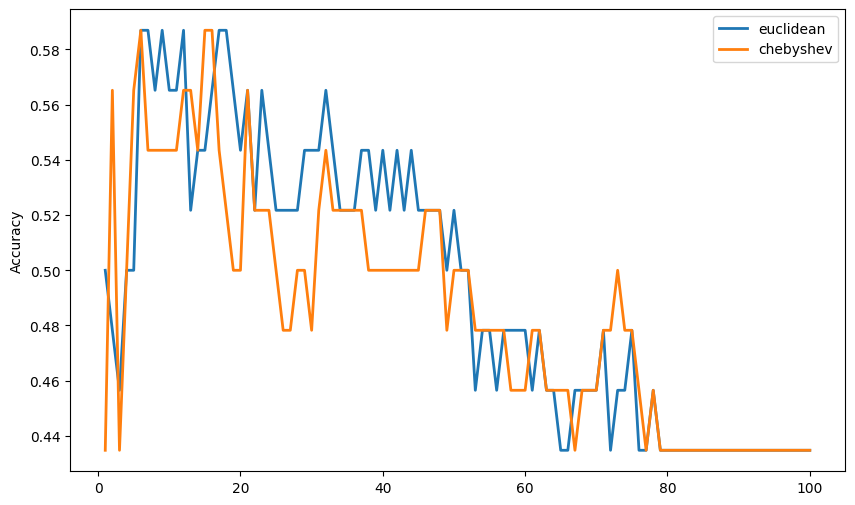

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=4)

fig,ax = plt.subplots(figsize=(10,6))
dict_metrics ={'euclidean':[], 'chebyshev':[]} 
k_vals = [i for i in range(1,101)]
scores = []

for metric in dict_metrics:
  for k in k_vals:
      knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
      knn.fit(X_train, y_train) 
      dict_metrics[metric].append(knn.score(X_test,y_test))

  plt.plot(np.array(k_vals), np.array(dict_metrics[metric]), lw = 2)
plt.ylabel('Accuracy')
plt.legend(dict_metrics.keys())
plt.show()


* Once we look at unseen testing data, there is in fact a "sweet spot" for $K$
* If we averaged this with CV or repeated samples, the profile would be smoother
* SKlearn does NOT standardize features before KNN to the best of my knowledge, be careful!
* We just tuned our first hyperparameter!

**Question**:
Could there also be issues of complexity, scalability? Think about what deployment and prediction mean if your model is KNN.